**Disclaimer:** Scraping data is often considered illegal and unethical if done without proper permissions. This project and its content are intended **solely for educational purposes** to demonstrate technical concepts. Data is scraped from https://seismonepal.gov.np/earthquakes

In [32]:
#scraping data

import requests
from bs4 import BeautifulSoup
import pandas as pd

# Scrape data from the website
base_url = "https://seismonepal.gov.np/earthquakes/index"

max_pages = 63  # Update as needed
# max_pages = 5  # to test

# Function to scrape data from a single page
def scrape_page(page_url):
    response = requests.get(page_url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Locate the table
    table = soup.find('table', {'class': 'table table-striped table-bordered'})
    rows = table.find('tbody').find_all('tr')

    data = []
    for row in rows:
        cols = row.find_all('td')
        cols = [col.text.strip() for col in cols]
        if cols:  # Check for non-empty rows
            data.append({
                'Date': cols[1],
                'Time': cols[2],
                'Latitude': str(cols[3]),
                'Longitude': str(cols[4]),
                'Magnitude': cols[5],
                'Epicenter': cols[6]
            })
    return data

# Main function to scrape multiple pages
def scrape_all_pages(base_url, max_pages):
    all_data = []
    for page in range(1, max_pages + 1):
        url = f"{base_url}?page={page}"
        page_data = scrape_page(url)
        all_data.extend(page_data)
        # print(f"Scraped page {page}") #this step can take some time, to see the progress of scraping data, uncomment this line
    return all_data

data = scrape_all_pages(base_url, max_pages)
# print(data)
print('data scraped updated')

data scraped updated


In [33]:
# --- Cleaning Functions ---

def clean_date(date_str):
    if 'A.D.:' in date_str:
        return date_str.split('A.D.:')[1].strip()
    return None

def clean_time(time_str):
    if 'Local:' in time_str:
        return time_str.split('Local:')[1].split('UTC:')[0].strip()
    return None

def clean_numeric(value):
    try:
        return float(str(value).replace(':', '.'))
    except ValueError:
        return None

def clean_epicenter(epicenter_str):
    # Remove asterisk and extra spaces
    return epicenter_str.replace('*', '').strip()

# --- Process Data ---

cleaned_data = []
for entry in data:
    cleaned_entry = {
        'Date': clean_date(entry['Date']),
        'Time': clean_time(entry['Time']),
        'Latitude': clean_numeric(entry['Latitude']),
        'Longitude': clean_numeric(entry['Longitude']),
        'Magnitude': clean_numeric(entry['Magnitude']),
        'Epicenter': clean_epicenter(entry['Epicenter'])
    }
    cleaned_data.append(cleaned_entry)

# --- Convert to DataFrame ---
df = pd.DataFrame(cleaned_data)

# Drop rows with missing coordinates
df = df.dropna(subset=['Latitude', 'Longitude'], how='any')

# Convert 'Date' to datetime.date
df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.date

# Combine 'Date' and 'Time' into full datetime
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'], errors='coerce')

# Save to CSV
df.to_csv('data/earthquake_data_nepal.csv', index=False)
print("✅ Data saved to earthquake_data_nepal.csv")


✅ Data saved to earthquake_data_nepal.csv


In [34]:
# Load data
df = pd.read_csv('data/earthquakes_with_districts.csv')

In [35]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               1253 non-null   object 
 1   Time               1253 non-null   object 
 2   Latitude           1253 non-null   float64
 3   Longitude          1253 non-null   float64
 4   Magnitude          1253 non-null   float64
 5   Epicenter          1253 non-null   object 
 6   Datetime           1253 non-null   object 
 7   Inferred_District  1191 non-null   object 
dtypes: float64(3), object(5)
memory usage: 78.4+ KB
None


In [5]:
# Display DataFrame
print(df)

            Date   Time  Latitude  Longitude  Magnitude      Epicenter  \
0     2025-04-04  20:10     28.96      82.12        5.5      Jajarkot*   
1     2025-04-04  20:07     28.95      82.12        5.2       Jajarkot   
2     2025-04-03  17:04     30.02      80.84        4.0       Darchula   
3     2025-03-26  19:44     29.69      81.82        4.5          Humla   
4     2025-03-26  18:27     28.70      86.74        5.5  Tingri, China   
...          ...    ...       ...        ...        ...            ...   
1232  1995-01-29  02:37     26.85      86.11        4.5        Dhanusa   
1233  1995-01-27  23:05     29.08      81.73        4.3        Kalikot   
1234  1995-01-22  11:58     27.90      87.80        4.0      Taplejung   
1235  1995-01-19  12:18     28.35      83.44        4.3         Myagdi   
1236  1995-01-05  17:23     29.82      80.95        4.4       Darchula   

                 Datetime  
0     2025-04-04 20:10:00  
1     2025-04-04 20:07:00  
2     2025-04-03 17:04:00  

In [6]:
print(df.describe())

          Latitude    Longitude    Magnitude
count  1237.000000  1237.000000  1237.000000
mean     28.286880    84.668448     4.445675
std       1.889076     2.140454     0.501429
min      23.710000    69.850000     4.000000
25%      27.730000    82.550000     4.100000
50%      27.940000    85.370000     4.300000
75%      28.620000    86.100000     4.600000
max      87.840000    89.880000     7.600000


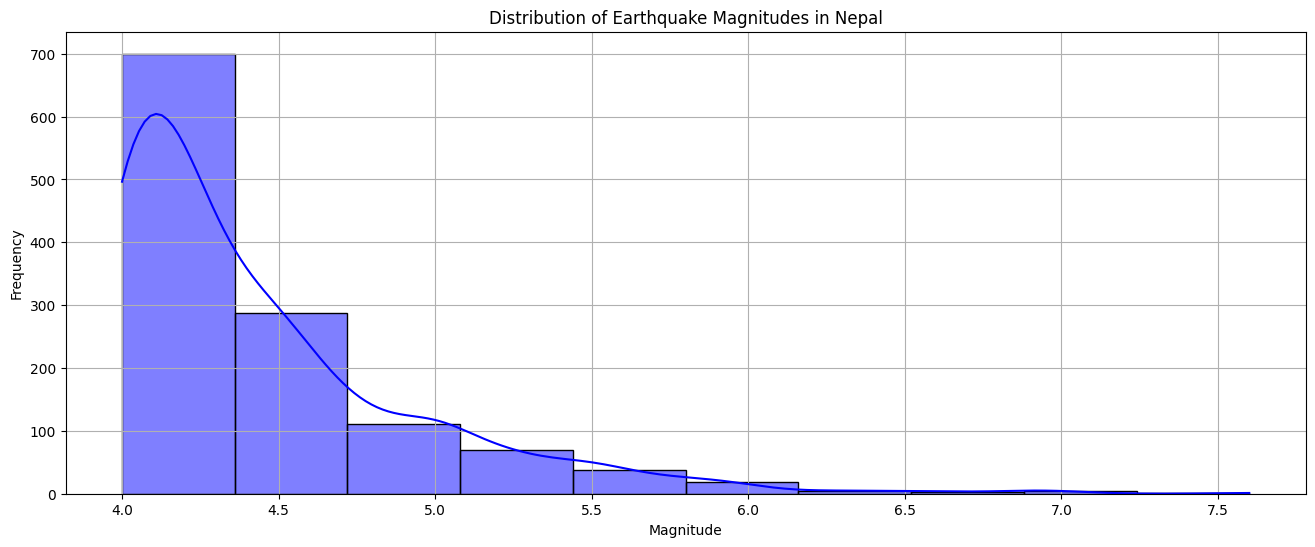

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization: Histogram of Magnitudes
plt.figure(figsize=(16, 6))  # Adjust figure size if needed
sns.histplot(df['Magnitude'], bins=10, kde=True, color='blue')
plt.title('Distribution of Earthquake Magnitudes in Nepal')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

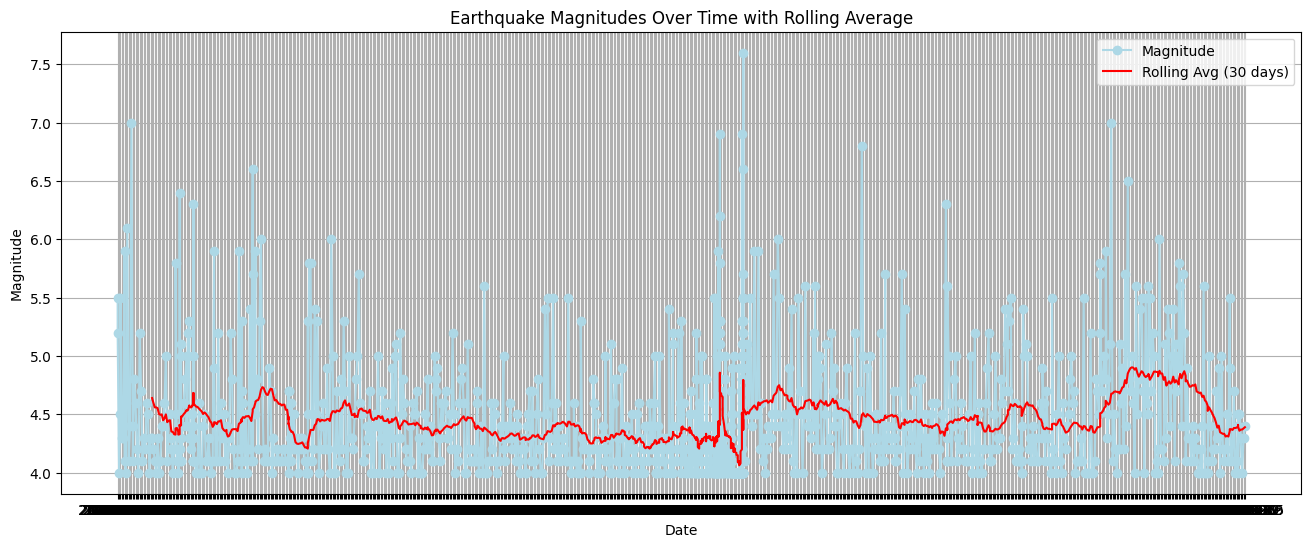

In [19]:
# Calculate Time Series Analysis with Rolling Averages
df['Rolling_Magnitude_Avg'] = df['Magnitude'].rolling(window=30).mean()

# Plot time series with rolling average
plt.figure(figsize=(16, 6))
plt.plot(df['Date'], df['Magnitude'], marker='o', linestyle='-', color='lightblue', label='Magnitude')
plt.plot(df['Date'], df['Rolling_Magnitude_Avg'], color='red', label='Rolling Avg (30 days)')
plt.title('Earthquake Magnitudes Over Time with Rolling Average')
plt.xlabel('Date')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()
plt.show()

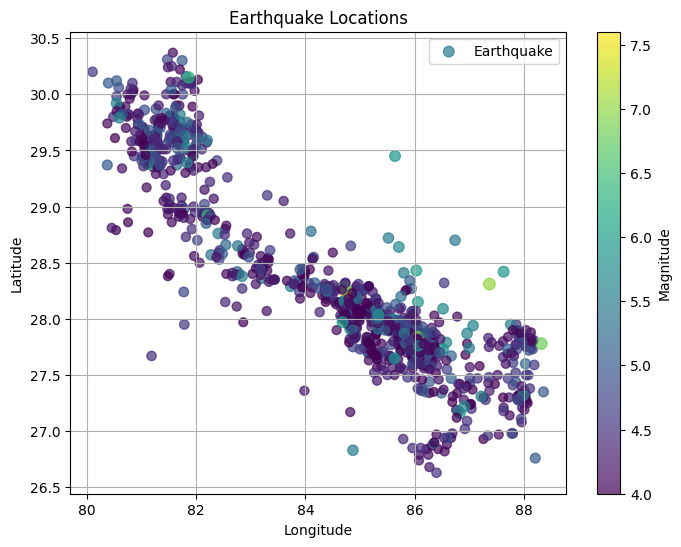

In [22]:
# Visualization: Scatter Plot of Earthquake Locations

# Define the bounding box for Nepal (approximate values)
min_latitude = 26.3
max_latitude = 30.5
min_longitude = 80.0
max_longitude = 88.5

# Filter the DataFrame
filtered_df = df[
    (df['Latitude'] >= min_latitude) & (df['Latitude'] <= max_latitude) &
    (df['Longitude'] >= min_longitude) & (df['Longitude'] <= max_longitude)
]
plt.figure(figsize=(8, 6))

cmap = 'viridis' # Using built-in colormap

plt.scatter(filtered_df['Longitude'], filtered_df['Latitude'],
            s=filtered_df['Magnitude']*10, alpha=0.7,
            c=filtered_df['Magnitude'], cmap=cmap, label='Earthquake')
plt.colorbar(label='Magnitude')
plt.title('Earthquake Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

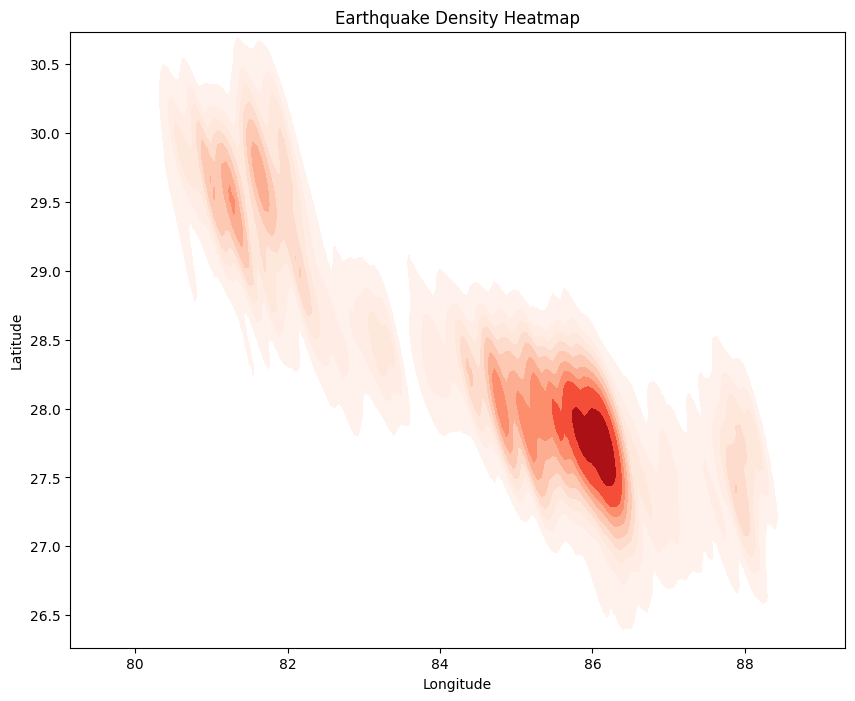

In [10]:
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.kdeplot(x=filtered_df['Longitude'], y=filtered_df['Latitude'], cmap="Reds", fill=True, bw_adjust=.5)
plt.title('Earthquake Density Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [23]:
# Code for Heatmap on Nepal Map
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster

# Initialize a map centered around Nepal
nepal_map = folium.Map(location=[28.3949, 84.1240], zoom_start=7)

# Prepare data for HeatMap
heat_data = df[['Latitude', 'Longitude', 'Magnitude']].values.tolist()

# Add HeatMap layer
HeatMap(heat_data, radius=15).add_to(nepal_map)

# Add a custom legend
legend_html = """
<div style="
    position: fixed; 
    bottom: 50px; left: 50px; width: 200px; height: 90px; 
    background-color: white; 
    border:2px solid grey; z-index:9999; font-size:14px;
    padding: 10px;
">
    <strong>Earthquake Magnitude</strong><br>
    <i style="background: rgba(255, 0, 0, 0.7); width: 20px; height: 10px; display: inline-block;"></i> High Magnitude<br>
    <i style="background: rgba(255, 165, 0, 0.7); width: 20px; height: 10px; display: inline-block;"></i> Medium Magnitude<br>
    <i style="background: rgba(0, 255, 0, 0.7); width: 20px; height: 10px; display: inline-block;"></i> Low Magnitude
</div>
"""

# Add legend to the map
nepal_map.get_root().html.add_child(folium.Element(legend_html))

# Initialize a MarkerCluster
marker_cluster = MarkerCluster().add_to(nepal_map)

# Add markers to the cluster
for _, row in df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"""
            <strong>Earthquake Details</strong><br>
            Magnitude: {row['Magnitude']}<br>
            Latitude: {row['Latitude']}<br>
            Longitude: {row['Longitude']}
        """
    ).add_to(marker_cluster)


# Save the map as an HTML file
nepal_map.save("nepal_earthquake_heatmap_with_legend.html")

print("Map saved to nepal_earthquake_heatmap_with_legend.html")
# Display the map (if running in a Jupyter Notebook or interactive environment)
nepal_map


Map saved to nepal_earthquake_heatmap_with_legend.html
